# NNet class in Pytorch

In this assignment you will complete an implementation of a neural network class that uses `pytorch`.  You will then use it to conduct some training experiments on specified data.  The data will be partitioned into some number of non-intersecting folds.  You will train, validate and test neural networks of various sizes on all ways of picking one fold to be testing, one fold to be validation, and remaining folds to be training sets.

## Implementation

In [1]:
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt

Complete the following definition of class `NNet` by completing its `train` and `use` functions.  These functions must be completed the *PyTorch* way, which is **not** identical to how you completed the network in A2 (though the same principles apply)!

In [2]:
class NNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, act_func='tanh'):
        super().__init__()  # call parent class (torch.nn.Module) constructor
        
        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        self.hidden_layers = torch.nn.ModuleList()  # necessary for model.to('cuda')

        for nh in self.n_hiddens_per_layer:
            self.hidden_layers.append( torch.nn.Sequential(
                torch.nn.Linear(n_inputs, nh),
                torch.nn.Tanh() if act_func == 'tanh' else torch.nn.ReLU()))
            
            n_inputs = nh

        self.output_layer = torch.nn.Linear(n_inputs, n_outputs)
            
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None

        self.error_trace = []
        
    def forward(self, X):
        Y = X
        for hidden_layer in self.hidden_layers:
            Y = hidden_layer(Y)
        Y = self.output_layer(Y)
        return Y

    def train(self, X, T, n_epochs, learning_rate, verbose=True):

        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).float()
            
        # Calculate standardization parameters if not already calculated
        if self.Xmeans is None:
            self.Xmeans = X.mean(0)
            self.Xstds = X.std(0)
            self.Xstds[self.Xstds == 0] = 1
            self.Tmeans = T.mean(0)
            self.Tstds = T.std(0)
            self.Tstds[self.Tstds == 0] = 1
            
        # Standardize inputs and targets
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds
        
        # Set optimizer to Adam and loss functions to MSELoss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        mse_func = torch.nn.MSELoss()

        # For each epoch:
        #   Do forward pass to calculate output Y.
        #   Calculate mean squared error loss, mse.
        #   Calculate gradient of mse with respect to all weights by calling mse.backward().
        #   Take weight update step, then zero the gradient values.
        #   Unstandardize the mse error and save in self.error_trace
        #   Print epoch+1 and unstandardized error if verbose is True and
        #             (epoch+1 is n_epochs or epoch+1 % (n_epochs // 10) == 0)
        
        for epoch in range(n_epochs):
            Y = self.forward(X)
            
            # mse = ((T - Y) ** 2).mean()
            mse = mse_func(T, Y)
            # gradient = mse.backward()
            mse.backward()
            
            # W -= learning_rate * gradient
            optimizer.step()
            optimizer.zero_grad()
            
            self.error_trace =  mse * self.Tstds
            
            if verbose and ((epoch + 1) == n_epochs or (epoch + 1) % (n_epochs // 10) == 0):
                print('Epoch', epoch + 1, ': RMSE', self.error_trace.item())
            

    def use(self, X):
        # Set input matrix to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
            
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        # Do forward pass and unstandardize resulting output. Assign to variable Y.
        predict = self.forward(X)
        Y = predict * self.Tstds + self.Tmeans

        # Return output Y after detaching from computation graph and converting to numpy
        return Y.detach().numpy()


## Example

In [3]:
torch.manual_seed(42)
np.random.seed(42)
    
n_samples = 10000
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = X ** 2

n_samples, n_inputs = X.shape 
n_outputs = T.shape[1]

n_hiddens = [100, 100]
net = NNet(n_inputs, n_hiddens, n_outputs, act_func='relu')
net.train(X, T, 50, 0.01)
Y = net.use(X)

def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

print(f'RMSE {rmse(Y, T):.3f}')

/usr/local/anaconda3/latest/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729009598/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch 5 : RMSE 4.173328876495361
Epoch 10 : RMSE 1.2323453426361084
Epoch 15 : RMSE 0.8960991501808167
Epoch 20 : RMSE 0.1482708603143692
Epoch 25 : RMSE 0.18003450334072113
Epoch 30 : RMSE 0.23297908902168274
Epoch 35 : RMSE 0.07177865505218506
Epoch 40 : RMSE 0.043323155492544174
Epoch 45 : RMSE 0.0459296740591526
Epoch 50 : RMSE 0.028481390327215195
RMSE 0.867


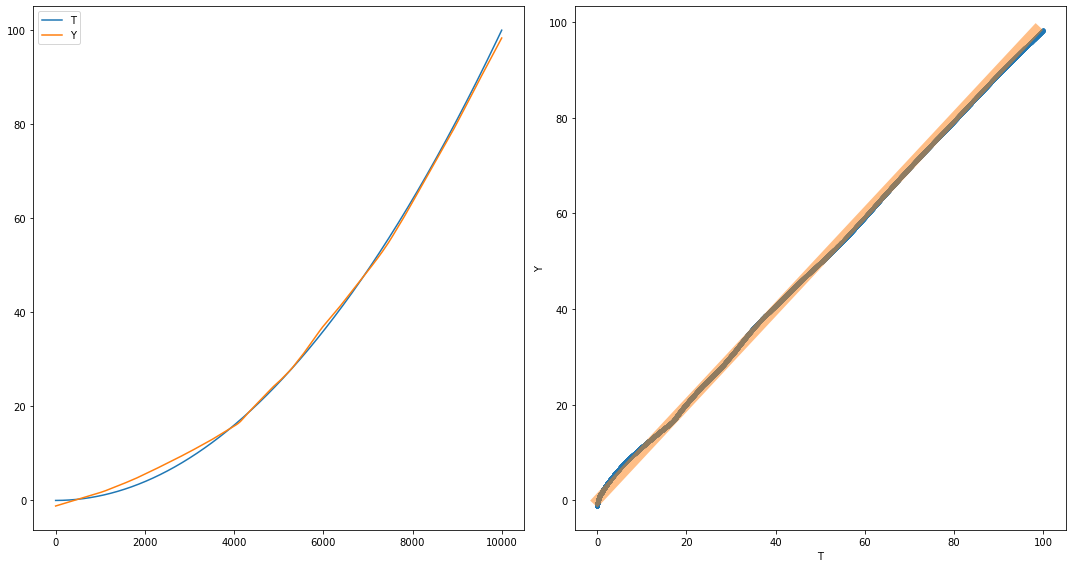

In [4]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(T, label='T')
plt.plot(Y, label='Y')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T, Y, '.')
a = max(np.min(T), np.min(Y))
b = min(np.max(T), np.max(Y))
plt.plot([a, b], [a, b], lw=10, alpha=0.5)
plt.xlabel('T')
plt.ylabel('Y')
plt.tight_layout()

# Function to generate all train, validate, and test partitions given number of folds

## Implementation

This is complete code for `generate_k_fold_cross_validation_sets`.

In [5]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

## Example

In [6]:
X = np.arange(2 * 6).reshape((6, 2))
T = np.arange(6).reshape((6, 1)) * 10
X, T

(array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]]),
 array([[ 0],
        [10],
        [20],
        [30],
        [40],
        [50]]))

In [7]:
np.random.seed(42)

for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, 3):
    print()
    print('Xtrain\n', Xtrain)
    print('Ttrain\n', Ttrain)
    print('Xvalidate\n', Xvalidate)
    print('Tvalidate\n', Tvalidate)
    print('Xtest\n', Xtest)
    print('Ttest\n', Ttest)
    


Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]


# Function to train NNets and average RMSE over all ways of partitioning

## Implementation

Define the following function that trains neural networks of different architectures, given by `list_of_n_hiddens`, for one value each of `n_epochs`, `learning_rate`, and `act_fun`.  For each network, train on all k-fold cross-validation training sets, and calculate the RMSEs for the training, validation and test. Calculate the mean of training, validation and test RMSEs over the k-fold partitions, so that you have one training, one validation, and one test set RMSE for each network.  Append a list of the architecture and these three mean RMSEs to a list of results and return the list as a pandas DataFrame described below when done.

To iterate over all k-fold partitions, use a for loop like the example in the previous code cell. Call `generate_k_fold_cross_validation_sets` with `shuffle=True`. 

In [8]:
def run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, n_epochs, learning_rate, act_func):
    
    for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, n_folds):
        results = []
        for n_hiddens in list_of_n_hiddens: # Layer sizes
            net = NNet(Xtrain.shape[1], n_hiddens, Ttrain.shape[1], act_func)
            net.train(Xtrain, Ttrain, n_epochs, learning_rate)
            # append the results of each experiment
            results.append([n_hiddens,
                            rmse(Ttrain, net.use(Xtrain)),
                            rmse(Tvalidate, net.use(Xvalidate)),
                            rmse(Ttest, net.use(Xtest))])
            # load these into a dataframe and give it some column titles
            df = pandas.DataFrame(results, columns=('Arch','Train RMSE','Validate RMSE', 'Test RMSE'))
    return df

## Apply to Airfoil Data

Download `airfoil_self_noise.dat` from [Airfoil Data Website](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) and read it as shown below.

In [9]:
airfoil = pandas.read_csv('airfoil_self_noise.dat', delimiter='\t',
                          names=('frequency', 'angle', 'chord', 
                                 'velocity', 'thickness', 'pressure'))
airfoils = airfoil.dropna()
data = airfoils.values
T2 = data[:, 5:]    # data[:,0] results in a one-dimensional matrix, data[:,0:1] preserves its two-dimensional nature.
X2 = data[:, 0:5]   # give me the input variables

T3 = data[:, 5:]   
X3 = data[:, 0:5]

T4 = data[:, 5:]   
X4 = data[:, 0:5]

T5 = data[:, 5:]   
X5 = data[:, 0:5]

T2,X2,airfoils

(array([[126.201],
        [125.201],
        [125.951],
        ...,
        [106.604],
        [106.224],
        [104.204]]),
 array([[8.00000e+02, 0.00000e+00, 3.04800e-01, 7.13000e+01, 2.66337e-03],
        [1.00000e+03, 0.00000e+00, 3.04800e-01, 7.13000e+01, 2.66337e-03],
        [1.25000e+03, 0.00000e+00, 3.04800e-01, 7.13000e+01, 2.66337e-03],
        ...,
        [4.00000e+03, 1.56000e+01, 1.01600e-01, 3.96000e+01, 5.28487e-02],
        [5.00000e+03, 1.56000e+01, 1.01600e-01, 3.96000e+01, 5.28487e-02],
        [6.30000e+03, 1.56000e+01, 1.01600e-01, 3.96000e+01, 5.28487e-02]]),
       frequency  angle   chord  velocity  thickness  pressure
 0           800    0.0  0.3048      71.3   0.002663   126.201
 1          1000    0.0  0.3048      71.3   0.002663   125.201
 2          1250    0.0  0.3048      71.3   0.002663   125.951
 3          1600    0.0  0.3048      71.3   0.002663   127.591
 4          2000    0.0  0.3048      71.3   0.002663   127.461
 ...         ...    ...     

Apply your `run_k_fold_cross_validation` to the airfoil data, with `X` being the first five columns of the data and `T` being the last column, the 'pressure'. 

Here is an example run.  You must try more neural network architectures.  Keep the following points in mind when you choose parameter values to try:
* Larger networks will require more epochs of training to converge.
* Large learning rates could limit convergence, but small learning rates may take many more epochs than you have patience for.
* Display results as a `pandas` `DataFrame` and in plots.  <font color=red>Your tabular results and plots must be described sufficiently.  If you struggle with judging this yourself, you can consider 10 sentences or more of discussion to be sufficient, but 9 perceptive sentences are better than 10 or more sentences of non-analytical fluff.</font>
* Name the columns of your `DataFrame` result to be `columns=('Arch', 'Train RMSE', 'Validate RMSE', 'Test RMSE'))`

In [10]:
X.shape, T.shape

((6, 2), (6, 1))

In [11]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [200, 200]],
                                      200, 0.01, 'tanh')



elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')


start2 = time.time()

results2 = run_k_fold_cross_validation(X2, T2, 5,
                                      [[], [1], [5], [100, 10]],
                                      100, 0.01, 'tanh')

elapsed2 = (time.time() - start2) / 60/ 60
print(f'Took {elapsed2:.2f} hours')




start3 = time.time()

results3 = run_k_fold_cross_validation(X3, T3, 5,
                                      [[], [1], [20], [500, 500]],
                                      1000, 0.0001, 'relu')

elapsed3 = (time.time() - start3) / 60/ 60
print(f'Took {elapsed3:.2f} hours')






start4 = time.time()

results4 = run_k_fold_cross_validation(X4, T4, 5,
                                      [[], [10], [500, 100]],
                                      500, 0.001, 'tanh')

elapsed4 = (time.time() - start4) / 60/ 60
print(f'Took {elapsed4:.2f} hours')





start5 = time.time()

results5 = run_k_fold_cross_validation(X5, T5, 5,
                                      [[], [10], [50], [1000, 100]],
                                      1000, 0.0001, 'relu')

elapsed5 = (time.time() - start5) / 60/ 60
print(f'Took {elapsed5:.2f} hours')

# def run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, n_epochs, learning_rate, act_func):

print(results)
print(results2)
print(results3)
print(results4)
print(results5)

Epoch 20 : RMSE 0.004048362839967012
Epoch 40 : RMSE 0.0036961808800697327
Epoch 60 : RMSE 0.0007780748419463634
Epoch 80 : RMSE 8.97364952834323e-05
Epoch 100 : RMSE 7.12415067027905e-06
Epoch 120 : RMSE 7.610125294377212e-07
Epoch 140 : RMSE 1.1446210379517652e-07
Epoch 160 : RMSE 1.899561041796005e-08
Epoch 180 : RMSE 2.9459132910858443e-09
Epoch 200 : RMSE 3.4459199382830263e-10
Epoch 20 : RMSE 11.583080291748047
Epoch 40 : RMSE 8.717463493347168
Epoch 60 : RMSE 5.7590227127075195
Epoch 80 : RMSE 2.3446996212005615
Epoch 100 : RMSE 0.6766694784164429
Epoch 120 : RMSE 0.2744845151901245
Epoch 140 : RMSE 0.21844735741615295
Epoch 160 : RMSE 0.19853606820106506
Epoch 180 : RMSE 0.17961665987968445
Epoch 200 : RMSE 0.1626591831445694
Epoch 20 : RMSE 7.387325763702393
Epoch 40 : RMSE 2.658905267715454
Epoch 60 : RMSE 0.7536695599555969
Epoch 80 : RMSE 0.16906481981277466
Epoch 100 : RMSE 0.13561567664146423
Epoch 120 : RMSE 0.11819566041231155
Epoch 140 : RMSE 0.10496041923761368
Epoch 

Epoch 120 : RMSE 0.028202956542372704
Epoch 140 : RMSE 0.025714458897709846
Epoch 160 : RMSE 0.023426895961165428
Epoch 180 : RMSE 0.021323714405298233
Epoch 200 : RMSE 0.01940525695681572
Epoch 20 : RMSE 3.5496926307678223
Epoch 40 : RMSE 0.09321694076061249
Epoch 60 : RMSE 0.03294627368450165
Epoch 80 : RMSE 0.001738909282721579
Epoch 100 : RMSE 0.0007696532993577421
Epoch 120 : RMSE 0.0001161942636827007
Epoch 140 : RMSE 1.3821011634718161e-05
Epoch 160 : RMSE 1.112147970161459e-06
Epoch 180 : RMSE 6.2694129887574945e-09
Epoch 200 : RMSE 2.3299945084431783e-08
Epoch 20 : RMSE 10.378201484680176
Epoch 40 : RMSE 3.3117048740386963
Epoch 60 : RMSE 0.9122859835624695
Epoch 80 : RMSE 0.2403794527053833
Epoch 100 : RMSE 0.05005812272429466
Epoch 120 : RMSE 0.006653542630374432
Epoch 140 : RMSE 0.0004843786882702261
Epoch 160 : RMSE 7.326732884394005e-06
Epoch 180 : RMSE 2.4693947580090025e-06
Epoch 200 : RMSE 1.231034275406273e-06
Epoch 20 : RMSE 10.676105499267578
Epoch 40 : RMSE 4.15050

Epoch 80 : RMSE 0.0189732164144516
Epoch 100 : RMSE 0.0067930277436971664
Epoch 120 : RMSE 0.0020501050166785717
Epoch 140 : RMSE 0.0005155466496944427
Epoch 160 : RMSE 0.00010602820839267224
Epoch 180 : RMSE 1.716149017738644e-05
Epoch 200 : RMSE 2.019530938923708e-06
Epoch 20 : RMSE 1.9136829376220703
Epoch 40 : RMSE 0.03246048837900162
Epoch 60 : RMSE 0.021822303533554077
Epoch 80 : RMSE 0.0016318464186042547
Epoch 100 : RMSE 0.0002795449981931597
Epoch 120 : RMSE 1.8286347767570987e-05
Epoch 140 : RMSE 6.692957867926452e-06
Epoch 160 : RMSE 4.52011448714984e-07
Epoch 180 : RMSE 7.203426832802506e-08
Epoch 200 : RMSE 1.0467698707827822e-08
Epoch 20 : RMSE 16.290067672729492
Epoch 40 : RMSE 7.607842922210693
Epoch 60 : RMSE 3.0055806636810303
Epoch 80 : RMSE 0.9772525429725647
Epoch 100 : RMSE 0.25329113006591797
Epoch 120 : RMSE 0.050050053745508194
Epoch 140 : RMSE 0.00696849450469017
Epoch 160 : RMSE 0.0005700085312128067
Epoch 180 : RMSE 1.3181008398532867e-05
Epoch 200 : RMSE 9.

Epoch 120 : RMSE 3.6844980058958754e-05
Epoch 140 : RMSE 0.00011926134902751073
Epoch 160 : RMSE 2.9600940251839347e-05
Epoch 180 : RMSE 7.519244036302553e-07
Epoch 200 : RMSE 1.3523504094337113e-07
Epoch 20 : RMSE 22.419666290283203
Epoch 40 : RMSE 11.15067195892334
Epoch 60 : RMSE 5.170812129974365
Epoch 80 : RMSE 2.7517290115356445
Epoch 100 : RMSE 1.9210487604141235
Epoch 120 : RMSE 1.5165096521377563
Epoch 140 : RMSE 1.1098463535308838
Epoch 160 : RMSE 0.6992508769035339
Epoch 180 : RMSE 0.40144339203834534
Epoch 200 : RMSE 0.21047444641590118
Epoch 20 : RMSE 3.272312879562378
Epoch 40 : RMSE 0.39522603154182434
Epoch 60 : RMSE 0.02659439668059349
Epoch 80 : RMSE 0.0020448025315999985
Epoch 100 : RMSE 0.00041949632577598095
Epoch 120 : RMSE 0.00010931710130535066
Epoch 140 : RMSE 2.56517123489175e-05
Epoch 160 : RMSE 4.735054517368553e-06
Epoch 180 : RMSE 5.869051165063865e-07
Epoch 200 : RMSE 3.3445452629621286e-08
Epoch 20 : RMSE 3.3824591636657715
Epoch 40 : RMSE 0.025947196409

Epoch 30 : RMSE 2.4450619220733643
Epoch 40 : RMSE 2.203819990158081
Epoch 50 : RMSE 2.0166878700256348
Epoch 60 : RMSE 1.8360227346420288
Epoch 70 : RMSE 1.626400351524353
Epoch 80 : RMSE 1.346015214920044
Epoch 90 : RMSE 1.0850319862365723
Epoch 100 : RMSE 0.8892186880111694
Epoch 10 : RMSE 9.535856246948242
Epoch 20 : RMSE 7.196450233459473
Epoch 30 : RMSE 5.6249494552612305
Epoch 40 : RMSE 4.643402099609375
Epoch 50 : RMSE 4.049612522125244
Epoch 60 : RMSE 3.6968493461608887
Epoch 70 : RMSE 3.493216037750244
Epoch 80 : RMSE 3.3793649673461914
Epoch 90 : RMSE 3.3176403045654297
Epoch 100 : RMSE 3.2852847576141357
Epoch 10 : RMSE 6.66653299331665
Epoch 20 : RMSE 6.212919235229492
Epoch 30 : RMSE 5.632842540740967
Epoch 40 : RMSE 5.008199691772461
Epoch 50 : RMSE 4.414811134338379
Epoch 60 : RMSE 3.9372076988220215
Epoch 70 : RMSE 3.5790107250213623
Epoch 80 : RMSE 3.3224103450775146
Epoch 90 : RMSE 3.1397647857666016
Epoch 100 : RMSE 3.0148143768310547
Epoch 10 : RMSE 4.7167601585388

Epoch 50 : RMSE 5.302839279174805
Epoch 60 : RMSE 4.781425952911377
Epoch 70 : RMSE 4.228514194488525
Epoch 80 : RMSE 3.7598564624786377
Epoch 90 : RMSE 3.439307689666748
Epoch 100 : RMSE 3.2326672077178955
Epoch 10 : RMSE 6.197071075439453
Epoch 20 : RMSE 5.01072359085083
Epoch 30 : RMSE 4.065567970275879
Epoch 40 : RMSE 3.539229393005371
Epoch 50 : RMSE 3.3199706077575684
Epoch 60 : RMSE 3.138292074203491
Epoch 70 : RMSE 3.00356388092041
Epoch 80 : RMSE 2.872169256210327
Epoch 90 : RMSE 2.735433340072632
Epoch 100 : RMSE 2.6010756492614746
Epoch 10 : RMSE 3.331254482269287
Epoch 20 : RMSE 2.746155261993408
Epoch 30 : RMSE 2.202798366546631
Epoch 40 : RMSE 1.9385883808135986
Epoch 50 : RMSE 1.797348976135254
Epoch 60 : RMSE 1.6947250366210938
Epoch 70 : RMSE 1.6097116470336914
Epoch 80 : RMSE 1.5373485088348389
Epoch 90 : RMSE 1.4529012441635132
Epoch 100 : RMSE 1.358036756515503
Epoch 10 : RMSE 5.88972282409668
Epoch 20 : RMSE 4.9908127784729
Epoch 30 : RMSE 4.370745658874512
Epoch 4

Epoch 40 : RMSE 2.0825626850128174
Epoch 50 : RMSE 1.7881085872650146
Epoch 60 : RMSE 1.5793118476867676
Epoch 70 : RMSE 1.350445032119751
Epoch 80 : RMSE 1.106562852859497
Epoch 90 : RMSE 0.9125131964683533
Epoch 100 : RMSE 0.7738324403762817
Epoch 10 : RMSE 5.060798645019531
Epoch 20 : RMSE 4.02890682220459
Epoch 30 : RMSE 3.536646842956543
Epoch 40 : RMSE 3.3335866928100586
Epoch 50 : RMSE 3.2628769874572754
Epoch 60 : RMSE 3.2463107109069824
Epoch 70 : RMSE 3.2415292263031006
Epoch 80 : RMSE 3.2367911338806152
Epoch 90 : RMSE 3.2328646183013916
Epoch 100 : RMSE 3.2305266857147217
Epoch 10 : RMSE 9.824418067932129
Epoch 20 : RMSE 7.96863317489624
Epoch 30 : RMSE 6.839873313903809
Epoch 40 : RMSE 6.058858394622803
Epoch 50 : RMSE 5.3850321769714355
Epoch 60 : RMSE 4.734990119934082
Epoch 70 : RMSE 4.164620399475098
Epoch 80 : RMSE 3.729351758956909
Epoch 90 : RMSE 3.433239459991455
Epoch 100 : RMSE 3.2483551502227783
Epoch 10 : RMSE 5.554154872894287
Epoch 20 : RMSE 4.344366073608398

Epoch 100 : RMSE 1.9442884922027588
Epoch 200 : RMSE 1.3799560070037842
Epoch 300 : RMSE 1.0364573001861572
Epoch 400 : RMSE 0.7924468517303467
Epoch 500 : RMSE 0.6078574061393738
Epoch 600 : RMSE 0.470056414604187
Epoch 700 : RMSE 0.3740907311439514
Epoch 800 : RMSE 0.3063868582248688
Epoch 900 : RMSE 0.25910070538520813
Epoch 1000 : RMSE 0.2224632203578949
Epoch 100 : RMSE 10.971832275390625
Epoch 200 : RMSE 10.695090293884277
Epoch 300 : RMSE 10.427024841308594
Epoch 400 : RMSE 10.16736125946045
Epoch 500 : RMSE 9.915837287902832
Epoch 600 : RMSE 9.672200202941895
Epoch 700 : RMSE 9.436206817626953
Epoch 800 : RMSE 9.207625389099121
Epoch 900 : RMSE 8.986228942871094
Epoch 1000 : RMSE 8.77180290222168
Epoch 100 : RMSE 11.122051239013672
Epoch 200 : RMSE 10.850667953491211
Epoch 300 : RMSE 10.594809532165527
Epoch 400 : RMSE 10.354637145996094
Epoch 500 : RMSE 10.128969192504883
Epoch 600 : RMSE 9.917409896850586
Epoch 700 : RMSE 9.717849731445312
Epoch 800 : RMSE 9.529520034790039
E

Epoch 500 : RMSE 5.228754997253418
Epoch 600 : RMSE 4.914006233215332
Epoch 700 : RMSE 4.627104759216309
Epoch 800 : RMSE 4.367408752441406
Epoch 900 : RMSE 4.134598255157471
Epoch 1000 : RMSE 3.9270541667938232
Epoch 100 : RMSE 1.8655403852462769
Epoch 200 : RMSE 1.3936021327972412
Epoch 300 : RMSE 1.0693680047988892
Epoch 400 : RMSE 0.8116881251335144
Epoch 500 : RMSE 0.6178708672523499
Epoch 600 : RMSE 0.4773559868335724
Epoch 700 : RMSE 0.37575963139533997
Epoch 800 : RMSE 0.30375444889068604
Epoch 900 : RMSE 0.25271251797676086
Epoch 1000 : RMSE 0.21451444923877716
Epoch 100 : RMSE 12.79419994354248
Epoch 200 : RMSE 12.485081672668457
Epoch 300 : RMSE 12.18491268157959
Epoch 400 : RMSE 11.893433570861816
Epoch 500 : RMSE 11.61038875579834
Epoch 600 : RMSE 11.335531234741211
Epoch 700 : RMSE 11.068629264831543
Epoch 800 : RMSE 10.809455871582031
Epoch 900 : RMSE 10.5577974319458
Epoch 1000 : RMSE 10.313448905944824
Epoch 100 : RMSE 7.362888336181641
Epoch 200 : RMSE 7.3091058731079

Epoch 900 : RMSE 9.52954387664795
Epoch 1000 : RMSE 9.323972702026367
Epoch 100 : RMSE 6.485635280609131
Epoch 200 : RMSE 6.077839374542236
Epoch 300 : RMSE 5.703222751617432
Epoch 400 : RMSE 5.35569953918457
Epoch 500 : RMSE 5.031094074249268
Epoch 600 : RMSE 4.727319240570068
Epoch 700 : RMSE 4.4491705894470215
Epoch 800 : RMSE 4.197046279907227
Epoch 900 : RMSE 3.9718244075775146
Epoch 1000 : RMSE 3.7696802616119385
Epoch 100 : RMSE 1.8463574647903442
Epoch 200 : RMSE 1.3561222553253174
Epoch 300 : RMSE 1.0242047309875488
Epoch 400 : RMSE 0.7817608714103699
Epoch 500 : RMSE 0.6000096797943115
Epoch 600 : RMSE 0.46856391429901123
Epoch 700 : RMSE 0.37349042296409607
Epoch 800 : RMSE 0.30662450194358826
Epoch 900 : RMSE 0.2579222619533539
Epoch 1000 : RMSE 0.22186894714832306
Epoch 100 : RMSE 11.11059284210205
Epoch 200 : RMSE 10.813468933105469
Epoch 300 : RMSE 10.526800155639648
Epoch 400 : RMSE 10.25023078918457
Epoch 500 : RMSE 9.983433723449707
Epoch 600 : RMSE 9.726093292236328


Epoch 100 : RMSE 10.48658561706543
Epoch 200 : RMSE 10.263622283935547
Epoch 300 : RMSE 10.039708137512207
Epoch 400 : RMSE 9.816545486450195
Epoch 500 : RMSE 9.593467712402344
Epoch 600 : RMSE 9.372907638549805
Epoch 700 : RMSE 9.152141571044922
Epoch 800 : RMSE 8.931661605834961
Epoch 900 : RMSE 8.712026596069336
Epoch 1000 : RMSE 8.495144844055176
Epoch 100 : RMSE 7.295984745025635
Epoch 200 : RMSE 6.779282093048096
Epoch 300 : RMSE 6.315459728240967
Epoch 400 : RMSE 5.88854455947876
Epoch 500 : RMSE 5.493097305297852
Epoch 600 : RMSE 5.128198623657227
Epoch 700 : RMSE 4.796387672424316
Epoch 800 : RMSE 4.496587753295898
Epoch 900 : RMSE 4.230593681335449
Epoch 1000 : RMSE 4.000253677368164
Epoch 100 : RMSE 1.9533179998397827
Epoch 200 : RMSE 1.3861843347549438
Epoch 300 : RMSE 1.0222218036651611
Epoch 400 : RMSE 0.749854564666748
Epoch 500 : RMSE 0.5499070882797241
Epoch 600 : RMSE 0.4135943651199341
Epoch 700 : RMSE 0.32275983691215515
Epoch 800 : RMSE 0.261196106672287
Epoch 900 

Epoch 150 : RMSE 1.0714267492294312
Epoch 200 : RMSE 0.6188570857048035
Epoch 250 : RMSE 0.41713467240333557
Epoch 300 : RMSE 0.3110617995262146
Epoch 350 : RMSE 0.2515663802623749
Epoch 400 : RMSE 0.21132634580135345
Epoch 450 : RMSE 0.18089264631271362
Epoch 500 : RMSE 0.1572849452495575
Epoch 50 : RMSE 9.93242073059082
Epoch 100 : RMSE 8.92951774597168
Epoch 150 : RMSE 8.086213111877441
Epoch 200 : RMSE 7.36900520324707
Epoch 250 : RMSE 6.757000923156738
Epoch 300 : RMSE 6.235713481903076
Epoch 350 : RMSE 5.793116092681885
Epoch 400 : RMSE 5.418512344360352
Epoch 450 : RMSE 5.102368354797363
Epoch 500 : RMSE 4.836280822753906
Epoch 50 : RMSE 6.484747886657715
Epoch 100 : RMSE 5.326537132263184
Epoch 150 : RMSE 4.462501049041748
Epoch 200 : RMSE 3.9322075843811035
Epoch 250 : RMSE 3.639007329940796
Epoch 300 : RMSE 3.4554736614227295
Epoch 350 : RMSE 3.303713798522949
Epoch 400 : RMSE 3.1492996215820312
Epoch 450 : RMSE 2.986241102218628
Epoch 500 : RMSE 2.829254627227783
Epoch 50 : 

Epoch 400 : RMSE 2.827887773513794
Epoch 450 : RMSE 2.7581522464752197
Epoch 500 : RMSE 2.6917898654937744
Epoch 50 : RMSE 2.188218593597412
Epoch 100 : RMSE 1.5318846702575684
Epoch 150 : RMSE 1.0239055156707764
Epoch 200 : RMSE 0.6489658951759338
Epoch 250 : RMSE 0.4299054741859436
Epoch 300 : RMSE 0.3172530233860016
Epoch 350 : RMSE 0.2568499743938446
Epoch 400 : RMSE 0.21693551540374756
Epoch 450 : RMSE 0.18611593544483185
Epoch 500 : RMSE 0.1607915461063385
Epoch 50 : RMSE 8.260248184204102
Epoch 100 : RMSE 7.396718978881836
Epoch 150 : RMSE 6.7333083152771
Epoch 200 : RMSE 6.186811923980713
Epoch 250 : RMSE 5.732101917266846
Epoch 300 : RMSE 5.353985786437988
Epoch 350 : RMSE 5.039684295654297
Epoch 400 : RMSE 4.778538227081299
Epoch 450 : RMSE 4.5616960525512695
Epoch 500 : RMSE 4.381722450256348
Epoch 50 : RMSE 5.373097896575928
Epoch 100 : RMSE 4.2298455238342285
Epoch 150 : RMSE 3.567445993423462
Epoch 200 : RMSE 3.2980782985687256
Epoch 250 : RMSE 3.1780219078063965
Epoch 30

Epoch 100 : RMSE 2.098071813583374
Epoch 200 : RMSE 1.6289316415786743
Epoch 300 : RMSE 1.3095307350158691
Epoch 400 : RMSE 1.0804799795150757
Epoch 500 : RMSE 0.8971136212348938
Epoch 600 : RMSE 0.7480736970901489
Epoch 700 : RMSE 0.6233400702476501
Epoch 800 : RMSE 0.522819459438324
Epoch 900 : RMSE 0.44277259707450867
Epoch 1000 : RMSE 0.3792368769645691
Epoch 100 : RMSE 12.354989051818848
Epoch 200 : RMSE 12.085137367248535
Epoch 300 : RMSE 11.825160026550293
Epoch 400 : RMSE 11.573704719543457
Epoch 500 : RMSE 11.33056640625
Epoch 600 : RMSE 11.095520973205566
Epoch 700 : RMSE 10.86829662322998
Epoch 800 : RMSE 10.648581504821777
Epoch 900 : RMSE 10.436063766479492
Epoch 1000 : RMSE 10.230420112609863
Epoch 100 : RMSE 5.658722400665283
Epoch 200 : RMSE 5.405851364135742
Epoch 300 : RMSE 5.183805465698242
Epoch 400 : RMSE 4.981279373168945
Epoch 500 : RMSE 4.79298734664917
Epoch 600 : RMSE 4.614832401275635
Epoch 700 : RMSE 4.446436405181885
Epoch 800 : RMSE 4.285317897796631
Epoch

Epoch 200 : RMSE 7.191509246826172
Epoch 300 : RMSE 6.434967517852783
Epoch 400 : RMSE 5.80898380279541
Epoch 500 : RMSE 5.2819671630859375
Epoch 600 : RMSE 4.835826396942139
Epoch 700 : RMSE 4.46065092086792
Epoch 800 : RMSE 4.145232677459717
Epoch 900 : RMSE 3.8840155601501465
Epoch 1000 : RMSE 3.668039321899414
Epoch 100 : RMSE 1.986263394355774
Epoch 200 : RMSE 1.520928978919983
Epoch 300 : RMSE 1.2077274322509766
Epoch 400 : RMSE 0.9625522494316101
Epoch 500 : RMSE 0.7927261590957642
Epoch 600 : RMSE 0.6653667688369751
Epoch 700 : RMSE 0.5622045397758484
Epoch 800 : RMSE 0.47150692343711853
Epoch 900 : RMSE 0.39863401651382446
Epoch 1000 : RMSE 0.33864060044288635
Epoch 100 : RMSE 10.934450149536133
Epoch 200 : RMSE 10.64738941192627
Epoch 300 : RMSE 10.374279022216797
Epoch 400 : RMSE 10.114360809326172
Epoch 500 : RMSE 9.866908073425293
Epoch 600 : RMSE 9.631211280822754
Epoch 700 : RMSE 9.406587600708008
Epoch 800 : RMSE 9.19237232208252
Epoch 900 : RMSE 8.987920761108398
Epoch

Epoch 500 : RMSE 6.042166233062744
Epoch 600 : RMSE 5.810596466064453
Epoch 700 : RMSE 5.575564861297607
Epoch 800 : RMSE 5.344385623931885
Epoch 900 : RMSE 5.119954586029053
Epoch 1000 : RMSE 4.903865814208984
Epoch 100 : RMSE 6.801069736480713
Epoch 200 : RMSE 6.120462417602539
Epoch 300 : RMSE 5.515438556671143
Epoch 400 : RMSE 4.968129634857178
Epoch 500 : RMSE 4.487920761108398
Epoch 600 : RMSE 4.08598518371582
Epoch 700 : RMSE 3.764836072921753
Epoch 800 : RMSE 3.513719320297241
Epoch 900 : RMSE 3.3201589584350586
Epoch 1000 : RMSE 3.166741132736206
Epoch 100 : RMSE 1.9176843166351318
Epoch 200 : RMSE 1.47599458694458
Epoch 300 : RMSE 1.1990102529525757
Epoch 400 : RMSE 0.9890490770339966
Epoch 500 : RMSE 0.8215219378471375
Epoch 600 : RMSE 0.6825805306434631
Epoch 700 : RMSE 0.5668443441390991
Epoch 800 : RMSE 0.471069872379303
Epoch 900 : RMSE 0.3911711275577545
Epoch 1000 : RMSE 0.3296006917953491
Epoch 100 : RMSE 12.67916488647461
Epoch 200 : RMSE 12.318619728088379
Epoch 300

Epoch 100 : RMSE 6.685227870941162
Epoch 200 : RMSE 6.4481000900268555
Epoch 300 : RMSE 6.219006061553955
Epoch 400 : RMSE 5.996819019317627
Epoch 500 : RMSE 5.7777299880981445
Epoch 600 : RMSE 5.5599822998046875
Epoch 700 : RMSE 5.343700885772705
Epoch 800 : RMSE 5.128855228424072
Epoch 900 : RMSE 4.909978866577148
Epoch 1000 : RMSE 4.6927876472473145
Epoch 100 : RMSE 6.575713157653809
Epoch 200 : RMSE 5.778176307678223
Epoch 300 : RMSE 5.1128106117248535
Epoch 400 : RMSE 4.5522685050964355
Epoch 500 : RMSE 4.08861780166626
Epoch 600 : RMSE 3.715409517288208
Epoch 700 : RMSE 3.423203229904175
Epoch 800 : RMSE 3.2032978534698486
Epoch 900 : RMSE 3.039497137069702
Epoch 1000 : RMSE 2.9136083126068115
Epoch 100 : RMSE 2.0005345344543457
Epoch 200 : RMSE 1.549889326095581
Epoch 300 : RMSE 1.2685810327529907
Epoch 400 : RMSE 1.0541094541549683
Epoch 500 : RMSE 0.874036431312561
Epoch 600 : RMSE 0.7202349901199341
Epoch 700 : RMSE 0.594781219959259
Epoch 800 : RMSE 0.4989067316055298
Epoch 

Here is a handy function to plot the RMSEs you have in your results table.  You may use this function to plot your results.  Remember to describe what you see.

In [12]:
def plot_results(results):
    errors = results.iloc[:, 1:].values
    archs = results.iloc[:, 0].values
    archs = [str(ar) for ar in archs]

    plt.plot(archs, errors, 'o-')
    plt.legend(('Train', 'Validate', 'Test'))
    plt.ylabel('RMSE')
    plt.xticks(range(errors.shape[0]), archs, rotation=45, ha='right')
    plt.tight_layout()

"\nThroughout my expirements I noticed that having two large hidden layers produce significantly better RMSE results\nfor both relu and tanh. The reason for this is that the activation functions have more attempts to learn the \ndata which increases the accuracy and produces low RMSE results. Another thing I noticed is that tanh requires less\nlarge parameters to produce as effective results as relu. What I mean by this is that the number of epochs could \nbe cut in half when using a tanh function over a relu function. The reason for this is that relu does better in \nlarge numbers. Since relu is a simple function that bends at one particular point, it is better to have a large \nnumber of relu line bends to map out the curve, this is best done with large value parameters. So this is why tanh \ncan have half the number of epochs which in turn means it doesn't require a very small learning rate either. \nWhich makes the program run faster. I also noticed that with a larger epoch number 

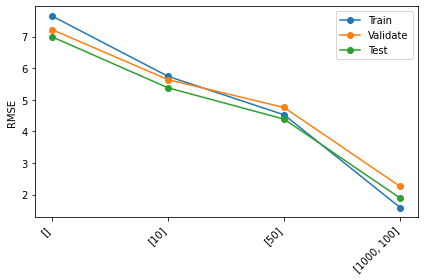

In [36]:
#plot_results(results)
#plot_results(results2)
#plot_results(results3)
#plot_results(results4)
plot_results(results5)

'''
Throughout my expirements I noticed that having two large hidden layers produce significantly better RMSE results
for both relu and tanh. The reason for this is that the activation functions have more attempts to learn the 
data which increases the accuracy and produces low RMSE results. Another thing I noticed is that tanh requires less
large parameters to produce as effective results as relu. What I mean by this is that the number of epochs could 
be cut in half when using a tanh function over a relu function. The reason for this is that relu does better in 
large numbers. Since relu is a simple function that bends at one particular point, it is better to have a large 
number of relu line bends to map out the curve, this is best done with large value parameters. So this is why tanh 
can have half the number of epochs which in turn means it doesn't require a very small learning rate either. 
Which makes the program run faster. I also noticed that with a larger epoch number and a smaller learning rate, the
RMSE values for Validate & Test have more consistency. Meaning that the range between the two tends to be smaller. 
Therefore, the two produce a better cluster. The Train RMSE value is a wildcard and can fall near a kind of far 
from the cluster.
'''


Original Network
Adam: Epoch 50 Error=0.21434
Adam: Epoch 100 Error=0.17178
Adam: Epoch 150 Error=0.15871
Adam: Epoch 200 Error=0.15296
Adam: Epoch 250 Error=0.14952
Adam: Epoch 300 Error=0.14743
Adam: Epoch 350 Error=0.14574
Adam: Epoch 400 Error=0.14409
Adam: Epoch 450 Error=0.14264
Adam: Epoch 500 Error=0.13966
First Network
First Network
   Hidden Layers     Train  Validate      Test      Time
0           [5]  5.228453  5.247232  5.226432  0.054089
Adam: Epoch 50 Error=0.15239
Adam: Epoch 100 Error=0.12216
Adam: Epoch 150 Error=0.11021
Adam: Epoch 200 Error=0.10346
Adam: Epoch 250 Error=0.09916
Adam: Epoch 300 Error=0.09596
Adam: Epoch 350 Error=0.09331
Adam: Epoch 400 Error=0.09136
Adam: Epoch 450 Error=0.08972
Adam: Epoch 500 Error=0.08846
Second Network
Second Network
   Hidden Layers     Train  Validate      Test      Time
0          [10]  5.229767  5.248451  5.227681  0.056225
Adam: Epoch 50 Error=0.12367
Adam: Epoch 100 Error=0.10235
Adam: Epoch 150 Error=0.09277
Adam: Epoch 200 Error=0.08695
Adam: Epoch 250 Error=0.08255
Adam: Epoch 300 Error=0.07908
Adam: Epoch 350 Error=0.07635
Adam: Epoch 400 Error=0.07407
Adam: Epoch 450 Error=0.07211
Adam: Epoch 500 Error=0.07034
Third Network
Third Network
   Hidden Layers     Train  Validate      Test      Time
0          [15]  5.230092  5.248703  5.227931  0.058947
Adam: Epoch 50 Error=0.10972
Adam: Epoch 100 Error=0.09148
Adam: Epoch 150 Error=0.08209
Adam: Epoch 200 Error=0.07558
Adam: Epoch 250 Error=0.07047
Adam: Epoch 300 Error=0.06622
Adam: Epoch 350 Error=0.06286
Adam: Epoch 400 Error=0.06013
Adam: Epoch 450 Error=0.05778
Adam: Epoch 500 Error=0.05591
Fourth Network
Fourth Network
   Hidden Layers     Train  Validate      Test      Time
0          [20]  5.230306  5.248853  5.228088  0.060406
Adam: Epoch 50 Error=0.10315
Adam: Epoch 100 Error=0.08434
Adam: Epoch 150 Error=0.07405
Adam: Epoch 200 Error=0.06656
Adam: Epoch 250 Error=0.06086
Adam: Epoch 300 Error=0.05643
Adam: Epoch 350 Error=0.05277
Adam: Epoch 400 Error=0.04970
Adam: Epoch 450 Error=0.04723
Adam: Epoch 500 Error=0.04503
Fifth Network
Fifth Network
   Hidden Layers     Train  Validate      Test      Time
0          [25]  5.230439  5.248945  5.228184  0.061965




Original Network
sgd: Epoch 50 Error=0.30226
sgd: Epoch 100 Error=0.30191
sgd: Epoch 150 Error=0.30157
sgd: Epoch 200 Error=0.30124
sgd: Epoch 250 Error=0.30091
sgd: Epoch 300 Error=0.30060
sgd: Epoch 350 Error=0.30028
sgd: Epoch 400 Error=0.29998
sgd: Epoch 450 Error=0.29968
sgd: Epoch 500 Error=0.29938
First Network
First Network
   Hidden Layers     Train  Validate      Test      Time
0           [5]  5.222283  5.241004  5.220223  0.053331
sgd: Epoch 50 Error=0.29898
sgd: Epoch 100 Error=0.29864
sgd: Epoch 150 Error=0.29830
sgd: Epoch 200 Error=0.29797
sgd: Epoch 250 Error=0.29765
sgd: Epoch 300 Error=0.29734
sgd: Epoch 350 Error=0.29703
sgd: Epoch 400 Error=0.29672
sgd: Epoch 450 Error=0.29642
sgd: Epoch 500 Error=0.29613
Second Network
Second Network
   Hidden Layers     Train  Validate      Test      Time
0          [10]  5.222318  5.241036  5.220257  0.056273
sgd: Epoch 50 Error=0.30084
sgd: Epoch 100 Error=0.30023
sgd: Epoch 150 Error=0.29965
sgd: Epoch 200 Error=0.29909
sgd: Epoch 250 Error=0.29855
sgd: Epoch 300 Error=0.29804
sgd: Epoch 350 Error=0.29755
sgd: Epoch 400 Error=0.29708
sgd: Epoch 450 Error=0.29664
sgd: Epoch 500 Error=0.29620
Third Network
Third Network
   Hidden Layers     Train  Validate      Test      Time
0          [15]  5.222297  5.241017  5.220236  0.058195
sgd: Epoch 50 Error=0.29944
sgd: Epoch 100 Error=0.29874
sgd: Epoch 150 Error=0.29809
sgd: Epoch 200 Error=0.29749
sgd: Epoch 250 Error=0.29693
sgd: Epoch 300 Error=0.29642
sgd: Epoch 350 Error=0.29595
sgd: Epoch 400 Error=0.29551
sgd: Epoch 450 Error=0.29510
sgd: Epoch 500 Error=0.29471
Fourth Network
Fourth Network
   Hidden Layers    Train  Validate      Test      Time
0          [20]  5.22233   5.24105  5.220268  0.060397
sgd: Epoch 50 Error=0.29818
sgd: Epoch 100 Error=0.29751
sgd: Epoch 150 Error=0.29690
sgd: Epoch 200 Error=0.29635
sgd: Epoch 250 Error=0.29586
sgd: Epoch 300 Error=0.29540
sgd: Epoch 350 Error=0.29499
sgd: Epoch 400 Error=0.29461
sgd: Epoch 450 Error=0.29426
sgd: Epoch 500 Error=0.29393
Fifth Network
Fifth Network
   Hidden Layers     Train  Validate      Test      Time
0          [25]  5.222379  5.241097  5.220315  0.062228




0	10.462287	1.094891	0.243309	0.0	16.970803	0.000000	0.000000	0.0	69.424169	1.804542
1	0.052836	0.862980	0.017612	0.0	98.467770	0.000000	0.000000	0.0	0.598802	0.000000
2	6.119163	4.830918	0.442834	0.0	34.802738	0.040258	0.000000	0.0	52.797907	0.966184
3	2.528916	2.293668	0.098020	0.0	47.284846	0.019604	0.000000	0.0	47.520094	0.254852
4	7.552994	3.231118	0.041161	0.0	64.416547	0.000000	0.000000	0.0	24.264252	0.493929
5	2.418997	1.575677	0.088771	0.0	56.879716	0.088771	0.000000	0.0	38.770528	0.177541
6	2.928701	21.531004	0.222177	0.0	37.467178	0.020198	0.000000	0.0	36.093718	1.737023
7	29.816425	0.695652	0.038647	0.0	52.309179	0.000000	0.019324	0.0	12.521739	4.599034
8	1.197852	7.992565	0.000000	0.0	38.021479	0.000000	0.000000	0.0	52.643536	0.144568
9	18.484362	2.105052	0.000000	0.0	57.377706	0.000000	0.000000	0.0	20.489174	1.543705




# Grading and Check-In

You will score 90 points if your `train`, `use`, an `run_k_fold_cross_validation` functions are defined correctly. You can test this grading process yourself by downloading [A3grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A3grader.zip) and extracting `A3grader.py` parallel to this notebook.  We recommend keeping this notebook and the grader script in a dedicated folder with *just those two files.* Run the code in the following cell to see an example grading run.  If your functions are defined correctly, you should see a score of 90/90.  The remaining 10 points will be based on 1) other testing and the results you obtain, and 2) your discussions.

In [14]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Infantes-A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='relu')
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='tanh')  # Using tanh
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(400)
    np.random.seed(400)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])
    
    results = run_k_

Epoch 700 : RMSE 0.0004400297184474766
Epoch 800 : RMSE 0.00029572349740192294
Epoch 900 : RMSE 0.0001904768869280815
Epoch 1000 : RMSE 0.00011874896881636232
Epoch 100 : RMSE 0.0010148277506232262
Epoch 200 : RMSE 0.00012579644680954516
Epoch 300 : RMSE 2.083188883261755e-05
Epoch 400 : RMSE 8.595980034442618e-06
Epoch 500 : RMSE 3.888021637976635e-06
Epoch 600 : RMSE 1.9247690943302587e-06
Epoch 700 : RMSE 0.00017614950775168836
Epoch 800 : RMSE 1.1639933745755116e-06
Epoch 900 : RMSE 8.383729550587304e-07
Epoch 1000 : RMSE 3.640749127953313e-05
Epoch 100 : RMSE 0.2105635553598404
Epoch 200 : RMSE 0.21047797799110413
Epoch 300 : RMSE 0.21047796308994293
Epoch 400 : RMSE 0.21047797799110413
Epoch 500 : RMSE 0.21047797799110413
Epoch 600 : RMSE 0.21047797799110413
Epoch 700 : RMSE 0.21047797799110413
Epoch 800 : RMSE 0.21047797799110413
Epoch 900 : RMSE 0.2104780077934265
Epoch 1000 : RMSE 0.2104780077934265
Epoch 100 : RMSE 0.28145068883895874
Epoch 200 : RMSE 0.14756949245929718
Epoc

Unlike A2, A3 **should be completed individually**.  Name your notebook as `Lastname-A3.ipynb` with Lastname being your last name, and then save this notebook and check it in at the A3 assignment link in our Canvas web page.

# Extra Credit

Earn up to 10 extra credit points on this assignment.

1. Add a keyword argument `gpu` that is `False` by default.  If set to `True`, move data and neural network model to the GPU and train and test it there.  Compare total execution time without and with the use of the GPU.  You may need to use one of the campus GPU machines for this.
2. Find another data set, not used previously in an assignment or in lecture, and repeat your training experiment without and with GPU on this new data.

Describe all results.  You can earn 5 points for doing (1) and another 5 for doing (2).